In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
df = pd.read_csv('cred doc casuality with preds.csv')
df

,PMID,id1,id2,is_in_same_sent,min_sents_window,sentence,in_neighbors,label,gda_score,gda_disparities,...,rs,vq*,Gene,Disease,gene abstract count,disease abstract count,gd abstract count,Causal_annotations_y,h,c
0,1834320,3073,D013661,False,1,Biochemistry genetics @ DiseaseTgt $ . @ Disea...,0 0 0 4 2|4 0 6|8 8 8 13 13 13 13 8 16 16 13 8...,1,0.650000,2.0,...,0.683532,1.000000,HEXA,Tay-Sachs Disease,8,8,8,8,0.0,9.0
1,10694284,3077,D006432,True,0,@ GeneSrc $ @ DiseaseTgt $ . @ DiseaseTgt $ co...,1 1 1 3|8 8 8 8 8 8 12 12 12 8 8 15 16 16 19 1...,1,0.650000,2.0,...,0.490790,0.553029,HFE,Hemochromatosis,10,19,10,7,0.0,5.0
2,11845294,1080,D003550,True,0,@ DiseaseTgt $ @ GeneSrc $ . @ DiseaseTgt $ ( ...,0 0 0 0 4|11 6 4 6 11 11 11 11 11 15 15 12 11 ...,1,0.573333,3.0,...,0.583243,0.979169,CFTR,Cystic Fibrosis,16,16,16,15,145.0,9.0
3,12416729,3077,D006432,True,0,@ GeneSrc $ @ GeneSrc $ @ DiseaseTgt $ . @ Dis...,0 0 3 0 0 5|11 7 5 7 11 11 11 14 14 11 16 17 1...,0,0.650000,2.0,...,0.515580,0.553029,HFE,Hemochromatosis,10,19,10,7,86.0,7.0
4,12416729,3077,D008107,False,1,@ GeneSrc $ @ GeneSrc $ hemochromatosis . Here...,0 0 3 0 0 6 12 8 6 8 12 12 12 15 15 12 17 18 1...,0,0.100000,1.0,...,0.515580,0.000000,HFE,Liver Diseases,10,1,1,0,86.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5262,35986530,57526,D004827,False,1,Genetics Dravet Syndrome Targeted Therapy Nano...,0 3 3 0 3 7 7 3 9 7 0 12 0 15 15 12 19 19 19 1...,1,NaN,2.0,...,0.038309,1.000000,PCDH19,Epilepsy,1,2,1,1,49.0,1.0
5263,35986530,6812,D004827,False,2,Genetics Dravet Syndrome Targeted Therapy Nano...,0 3 3 0 3 7 7 3 9 7 0 12 0 15 15 12 19 19 19 1...,0,NaN,2.0,...,0.038309,0.000000,STXBP1,Epilepsy,1,2,1,0,49.0,1.0
5264,35986530,6326,D004827,False,2,Genetics Dravet Syndrome Targeted Therapy Nano...,0 3 3 0 3 7 7 3 9 7 0 12 0 15 15 12 19 19 19 1...,0,NaN,2.0,...,0.038309,0.000000,SCN2A,Epilepsy,2,2,2,0,49.0,1.0
5265,35986530,6323,D004827,False,1,Genetics Dravet Syndrome Targeted Therapy Nano...,0 3 3 0 3 7 7 3 9 7 0 12 0 15 15 12 19 19 19 1...,1,NaN,3.0,...,0.038309,0.185415,SCN1A,Epilepsy,2,2,2,1,49.0,1.0


In [33]:
import numpy as np
import pandas as pd

# Define initial weights vector for the features
beta = np.ones(3) / np.sqrt(3)  # [1/sqrt(3), 1/sqrt(3), 1/sqrt(3)]
lam=0.01

tolerance = 1e-4
delta_norm = np.inf

# Extract features as vectors
f1, f2, f3 = df['H-Index'].values, df['Citations'].values, df['Year difference'].values
fs = np.vstack((f1, f2, f3)).T

# Step 1: Initialize the reliability score (rs) for all sources (PMIDs)
df['rs'] = fs @ beta

# Create a dictionary for gene-disease pairs (gd_pair) and their associated sources and predictions
gd_pair_dict = {}
src_pair_dict = {}

for _, row in df.iterrows():
    gd_pair = (row['id1'], row['id2'])
    src = row['PMID']
    rs = row['rs']
    vqs = row['label']
    
    if gd_pair not in gd_pair_dict:
        gd_pair_dict[gd_pair] = []
    
    gd_pair_dict[gd_pair].append((src, rs, vqs))
    
    if src not in src_pair_dict:
        src_pair_dict[src] = []
    
    src_pair_dict[src].append((gd_pair, vqs))

# Initialize vq_star_dict for each GD pair
vq_star_dict = {}

# Step 2: Initialize rs_dict for all sources (PMIDs)
rs_dict = {}
for _, row in df.iterrows():
    src = row['PMID']
    rs = row['rs']
    rs_dict[src] = rs

# Iterative process to update beta and calculate reliable causal values (vq*)
it = 0
prev_beta = np.copy(beta)
beta_diff_norm = np.linalg.norm(prev_beta)
while beta_diff_norm > tolerance:
    it += 1
    # Step 4: Recalculate vq* for each unique GD pair
    for gd_pair, source_rs_list in gd_pair_dict.items():
        # Extract source and vqs values
        src_values = np.array([src for src, _, _ in source_rs_list])
        vqs_values = np.array([vqs for _, _, vqs in source_rs_list])
        
        # Fetch corresponding rs values for each src from rs_dict
        rs_values = np.array([rs_dict[src] for src in src_values])

        numerator = (np.sum(rs_values * (vqs_values == 1).astype(float)) + lam * np.sum(rs_values * (vqs_values == 0).astype(float) * vqs_values))
        
        denominator = (np.sum(rs_values * (vqs_values == 1).astype(float)) + lam * np.sum(rs_values * (vqs_values == 0).astype(float)))

        vq_star = numerator / denominator if denominator != 0 else 0
        # vq_star = numerator
        vq_star_dict[gd_pair] = vq_star

    # Step 5: Update beta vector based on delta
    delta = np.zeros(3)

    delta_yes = np.zeros(3)
    delta_no = np.zeros(3)
    
    for i, feature_col in enumerate(['H-Index', 'Citations', 'Year difference']):
        for src, gd_pairs_info in src_pair_dict.items():
            for gd_pair, vqs in gd_pairs_info:
                if gd_pair not in vq_star_dict:
                    continue
                vq_star = vq_star_dict[gd_pair]
                feature_value = df[df['PMID'] == src][feature_col].values[0]
    
                if vqs == 1:  # YES case
                    sim_val = vq_star  # from board
                    delta_yes[i] += feature_value * sim_val
                else:          # NO case
                    sim_val = vq_star
                    delta_no[i] += feature_value * sim_val
    
    # Combine YES and NO contributions
    delta = delta_yes + lam * delta_no
    
    # Normalize for beta
    beta = delta / np.linalg.norm(delta)
    
    # Recalculate reliability scores (rs) with updated beta
    df['rs'] = fs @ beta
    
    # Update rs_dict with new rs values
    for _, row in df.iterrows():
        src = row['PMID']
        rs_dict[src] = row['rs']

    # Check stopping criterion (norm of current beta - previous beta)
    beta_diff_norm = np.linalg.norm(beta - prev_beta)
    # print(it, beta, beta_diff_norm)
    if beta_diff_norm < tolerance:
        break  # Stop if difference between current and previous beta is less than tolerance
    prev_beta = np.copy(beta) 
     

# Step 6: Map the final trustworthy causal values (vq*) to the DataFrame
df['vq*'] = df.apply(lambda row: vq_star_dict.get((row['id1'], row['id2']), np.nan), axis=1)

# Output final reliability scores and vq* for each GD pair
print("Final reliability scores (rs):\n", df[['PMID', 'rs']])
print("\nFinal trustworthy causal values (vq*):\n", df[['GD pair', 'vq*']])


1 [0.64412528 0.23064231 0.72931937] 0.38439552743498007
2 [0.6440682  0.23051497 0.72941004] 0.00016641887424308138
3 [0.64406807 0.23051492 0.72941017] 1.84524465483501e-07
Final reliability scores (rs):
           PMID        rs
0      1834320  0.732304
1     10694284  0.525871
2     11845294  0.609060
3     12416729  0.543022
4     12416729  0.543022
...        ...       ...
5262  35986530  0.035702
5263  35986530  0.035702
5264  35986530  0.035702
5265  35986530  0.035702
5266  35986530  0.035702

[5267 rows x 2 columns]

Final trustworthy causal values (vq*):
                      GD pair       vq*
0     HEXA-Tay-Sachs Disease  1.000000
1        HFE-Hemochromatosis  0.992185
2       CFTR-Cystic Fibrosis  0.999778
3        HFE-Hemochromatosis  0.992185
4         HFE-Liver Diseases  0.000000
...                      ...       ...
5262         PCDH19-Epilepsy  1.000000
5263         STXBP1-Epilepsy  0.000000
5264          SCN2A-Epilepsy  0.000000
5265          SCN1A-Epilepsy  0.95318

In [34]:
df.columns

Index(['PMID', 'id1', 'id2', 'is_in_same_sent', 'min_sents_window', 'sentence',
       'in_neighbors', 'label', 'gda_score', 'gda_disparities', 'Journal_name',
       'Url', 'H-Index', 'Year', 'Citations', 'gda_avg', 'prediction',
       'Causal_annotations_x', 'Causal/Total', 'PMID_unique', 'GD pair',
       'Year difference', 'rs', 'vq*', 'Gene', 'Disease',
       'gene abstract count', 'disease abstract count', 'gd abstract count',
       'Causal_annotations_y', 'h', 'c'],
      dtype='object')

In [35]:
df[['PMID', 'rs']].sort_values(by='rs', ascending=True).drop_duplicates(subset='PMID', keep='first')

,PMID,rs
4413,37182889,0.000000
4425,37387251,0.000000
4408,36764358,0.000321
3835,36604975,0.000643
4414,37291760,0.000643
...,...,...
507,20542038,0.694847
2530,33229544,0.706453
0,1834320,0.732304
106,17545194,0.829795


In [36]:

rs_sum = df.groupby(['id1', 'id2'])['rs'].sum().reset_index()
rs_sum.rename(columns={'rs': 'rs_sum'}, inplace=True)
df = df.merge(rs_sum, on=['id1', 'id2'], how='left')
df['vq*_weighted'] = df['vq*'] * df['rs_sum']

df['vq*_weighted']

0       2.211170
1       6.169440
2       4.660036
3       6.169440
4       0.000000
          ...   
5262    0.071404
5263    0.000000
5264    0.000000
5265    0.402333
5266    0.000000
Name: vq*_weighted, Length: 5267, dtype: float64

In [37]:
df_grouped_gd = df.groupby(['id1','id2'])[['vq*', 'gene abstract count', 
                                   'disease abstract count', 'gd abstract count']].mean().reset_index()

df_grouped_gd = df_grouped_gd.sort_values(by='vq*', ascending=False).reset_index(drop=True)

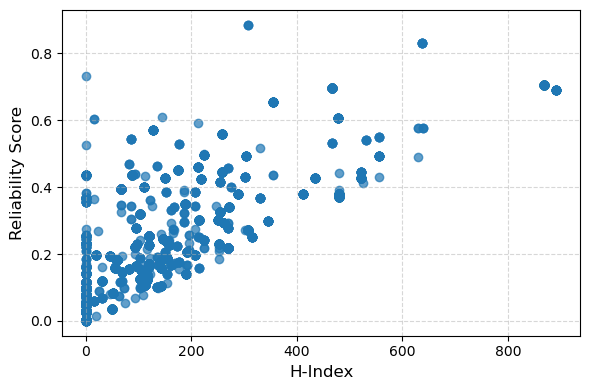

In [42]:
import matplotlib.pyplot as plt

# Scatter plot of h vs vq*_weighted
plt.figure(figsize=(6, 4))
plt.scatter(df['h'], df['rs'], alpha=0.7)

# Labels and title
plt.xlabel('H-Index', fontsize=12)
plt.ylabel('Reliability Score', fontsize=12)
# plt.title('Scatter Plot: h vs rs', fontsize=14)

# Optional: grid and layout
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('./Figures/h_vs_rs_scatter_plot.png', dpi=300, bbox_inches='tight')


# Show the plot
plt.show()


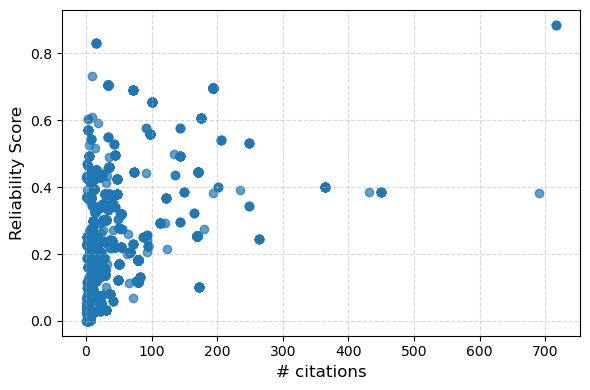

In [49]:
import matplotlib.pyplot as plt

# Scatter plot of h vs vq*_weighted
plt.figure(figsize=(6, 4))
plt.scatter(df['c'], df['rs'], alpha=0.7)

# Labels and title
plt.xlabel('# citations', fontsize=12)
plt.ylabel('Reliability Score', fontsize=12)
# plt.title('Scatter Plot: c vs rs', fontsize=14)

# Set x-axis limit to 300
# plt.xlim(0, 100)
# # Set x-axis to log scale
# plt.xscale('log')

# Optional: grid and layout
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig('./Figures/c_vs_rs_scatter_plot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [57]:
import scipy.stats as stats

spearman_corr, p_value = stats.spearmanr(df['h'], df['rs'])
print(f"Spearman correlation coefficient between H-index and reliability score: {spearman_corr:.3f}")
# print(f"P-value: {p_value:.6f}")

spearman_corr, p_value = stats.spearmanr(df['c'], df['rs'])
print(f"Spearman correlation coefficient between citations and reliability score: {spearman_corr:.3f}")
# print(f"P-value: {p_value:.6f}")

spearman_corr, p_value = stats.spearmanr(df['Year'], df['rs'])
print(f"Spearman correlation coefficient between YoP and reliability score: {spearman_corr:.3f}")
# print(f"P-value: {p_value:.6f}")

Spearman correlation coefficient between H-index and reliability score: 0.717
Spearman correlation coefficient between citations and reliability score: 0.373
Spearman correlation coefficient between YoP and reliability score: -0.742


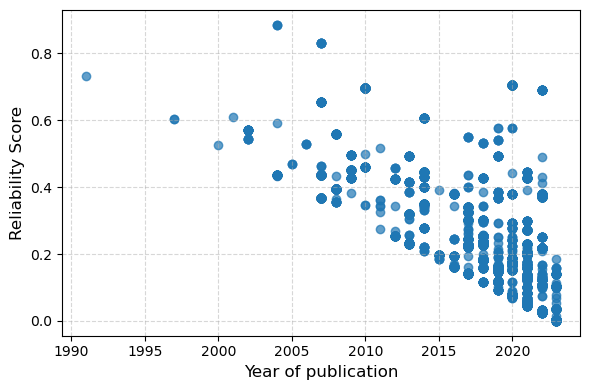

In [44]:
import matplotlib.pyplot as plt

# Scatter plot of h vs vq*_weighted
plt.figure(figsize=(6, 4))
plt.scatter(df['Year'], df['rs'], alpha=0.7)

# Labels and title
plt.xlabel('Year of publication', fontsize=12)
plt.ylabel('Reliability Score', fontsize=12)
# plt.title('Scatter Plot: yop vs rs', fontsize=14)

# Optional: grid and layout
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('./Figures/yop_vs_rs_scatter_plot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
